In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
print('TF',tf.__version__)

TF 2.5.0


In [20]:
BASE = '../data/train_images/'

In [21]:
train = pd.read_csv('../data/subset_test.csv')

In [22]:
model = tf.keras.models.load_model("model.h5")
model = model.layers[2]
# model = EfficientNetB0(weights='imagenet',include_top=False, pooling='avg', input_shape=None)

In [23]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, img_size=256, batch_size=32, path=BASE): 
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.path = path
        self.indexes = np.arange( len(self.df) )
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.df) // self.batch_size
        ct += int(( (len(self.df)) % self.batch_size)!=0)
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indexes)
        return X
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        X = np.zeros((len(indexes),self.img_size,self.img_size,3),dtype='float32')
        df = self.df.iloc[indexes]
        for i,(index,row) in enumerate(df.iterrows()):
            img = cv2.imread(self.path+row.image)
            X[i,] = cv2.resize(img,(self.img_size,self.img_size)) #/128.0 - 1.0
        return X

In [24]:
# import pandas as pd
# import os
# from meta.paths import PATH_TO_DATA, PATH_TO_TRAINING_IMAGES
# path_to_training_data = os.path.join(PATH_TO_DATA, "train.csv")
# train_df = pd.read_csv(path_to_training_data)
# train_df['target'] = train_df.label_group.map(train_df.groupby('label_group').posting_id.agg('unique').to_dict())
# train_df['target'] = train_df['target'].apply(list)

In [26]:
model.summary()

Model: "FeatureGenerationModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
FeatureNet_ImageInput (Input [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 98, 8)         224       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 8)         32        
_________________________________________________________________
activation (Activation)      (None, 98, 98, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 

In [27]:
train_gen = DataGenerator(train, img_size=100, batch_size=128)
image_embeddings = model.predict(train_gen, verbose=1)
# from preprocessing.data_generator import build_plain_generator
# generator = build_plain_generator()
# image_embeddings = model.predict(generator.flow_from_dataframe(train_df, x_col='image', target_size=(100, 100), y_col='target', directory=PATH_TO_TRAINING_IMAGES))

27/27 [==============================] - 16s 593ms/step


In [31]:
from sklearn.neighbors import NearestNeighbors
KNN = 50
model = NearestNeighbors(n_neighbors=KNN, metric='cosine')
model.fit(image_embeddings)
distances, indices = model.kneighbors(image_embeddings)

In [32]:
def displayDF(train, random=False, COLS=6, ROWS=4, path=BASE):
    for k in range(ROWS):
        plt.figure(figsize=(20,5))
        for j in range(COLS):
            if random: row = np.random.randint(0, len(train))
            else: row = COLS*k + j
            name = train.iloc[row, 1]
            title = train.iloc[row, 3]
            title_with_return = ""
            for i,ch in enumerate(title):
                title_with_return += ch
                if (i!=0)&(i%20==0): title_with_return += '\n'
            img = cv2.imread(path+name)
            plt.subplot(1,COLS,j+1)
            plt.title(title_with_return)
            plt.axis('off')
            plt.imshow(img)
        plt.show()

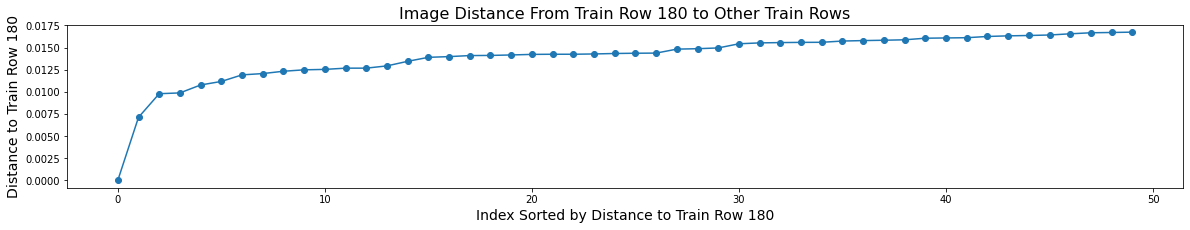

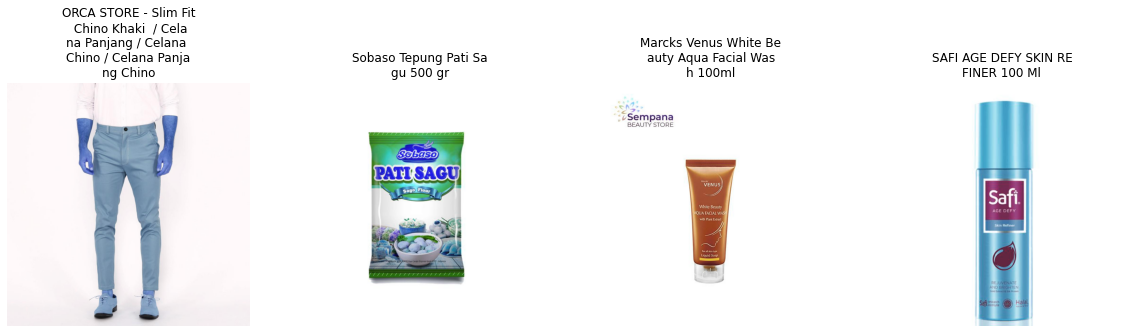

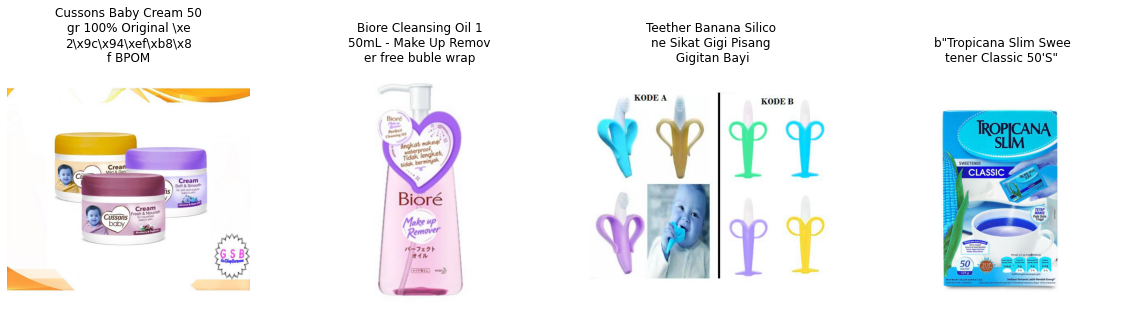

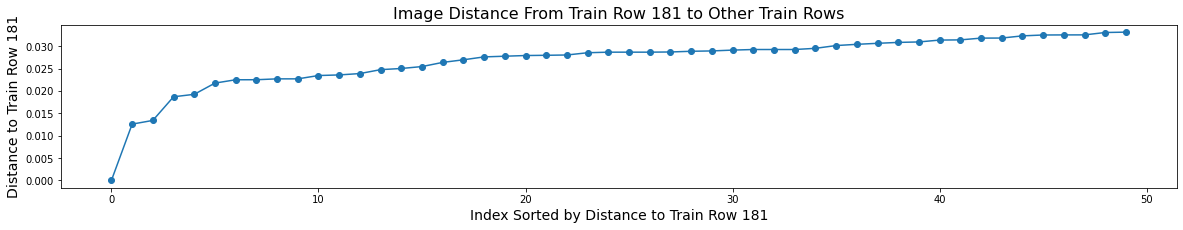

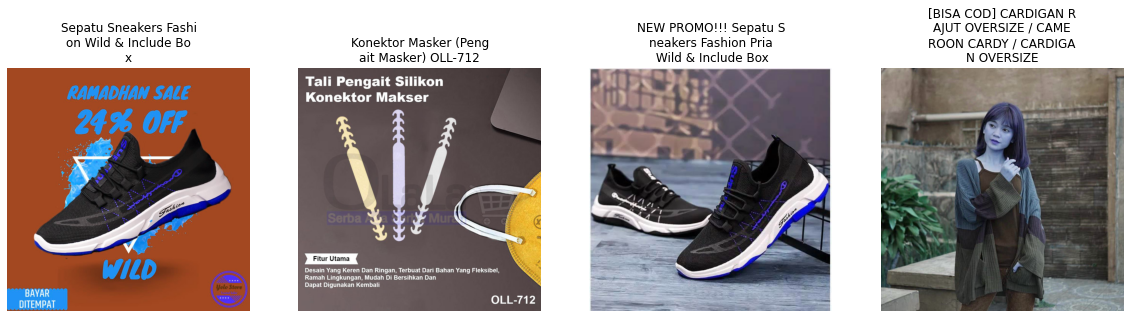

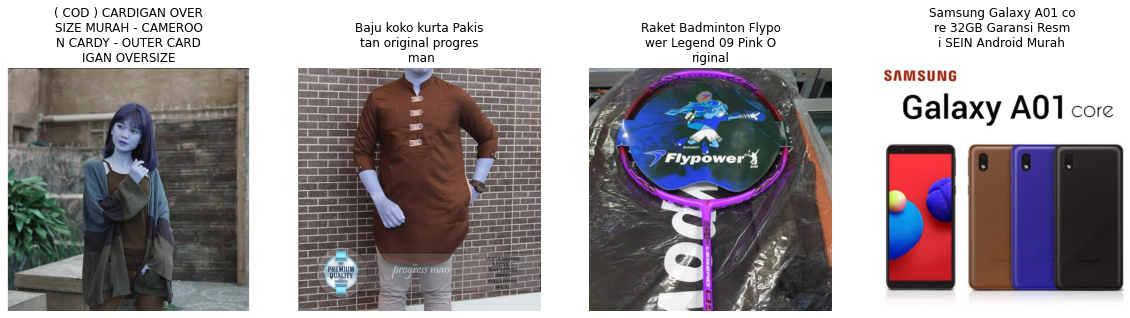

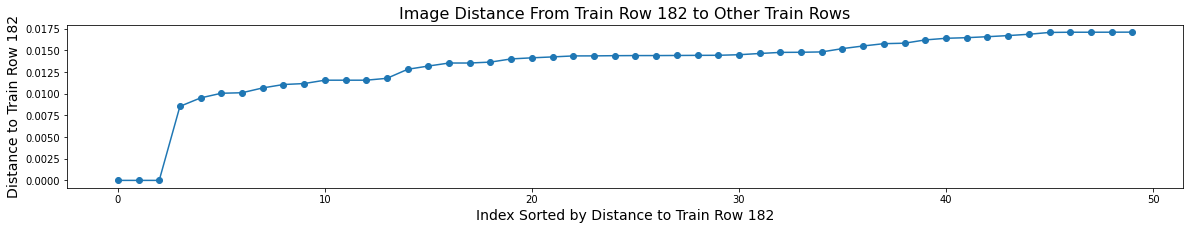

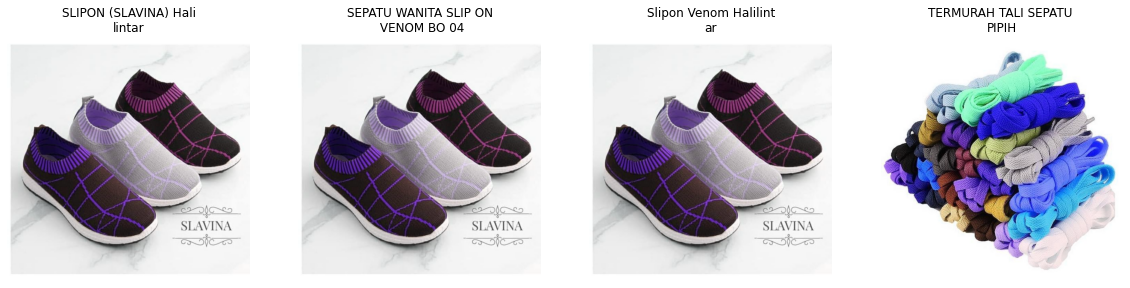

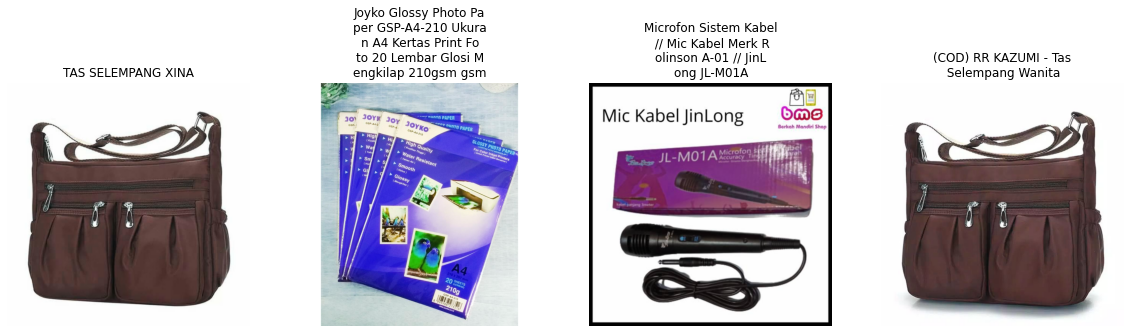

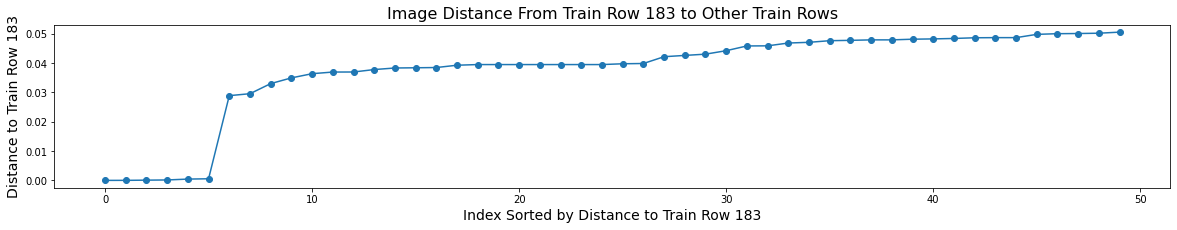

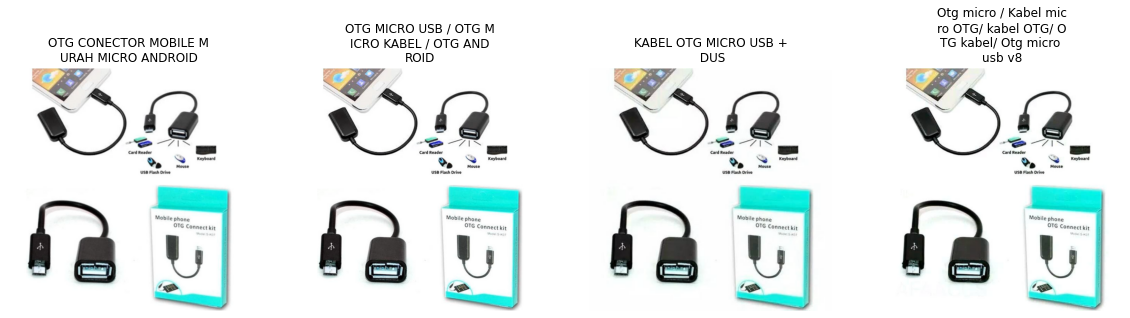

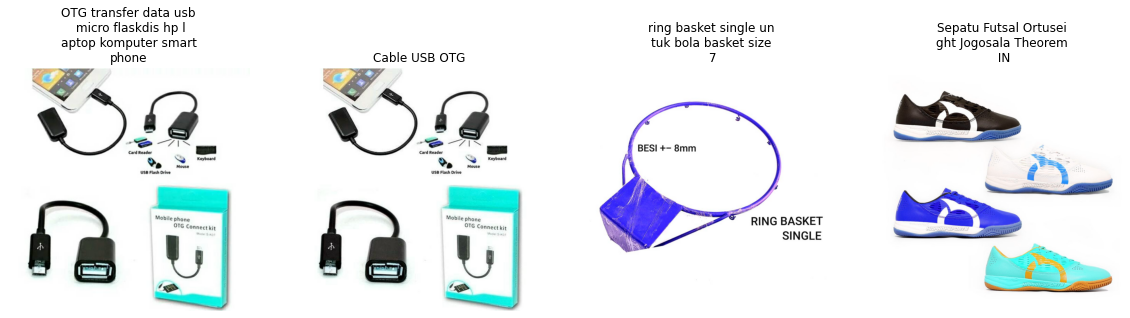

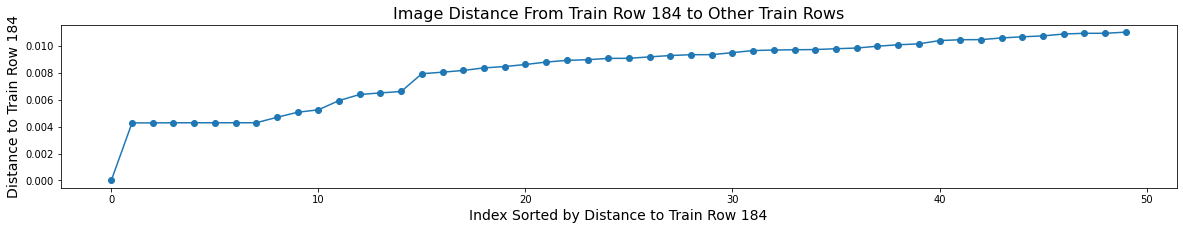

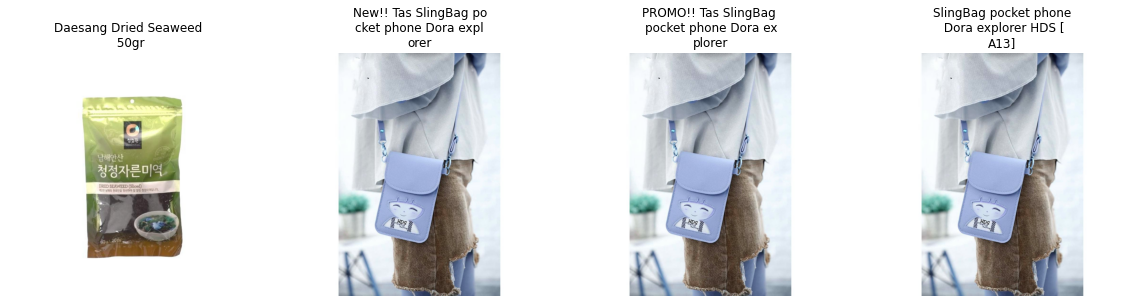

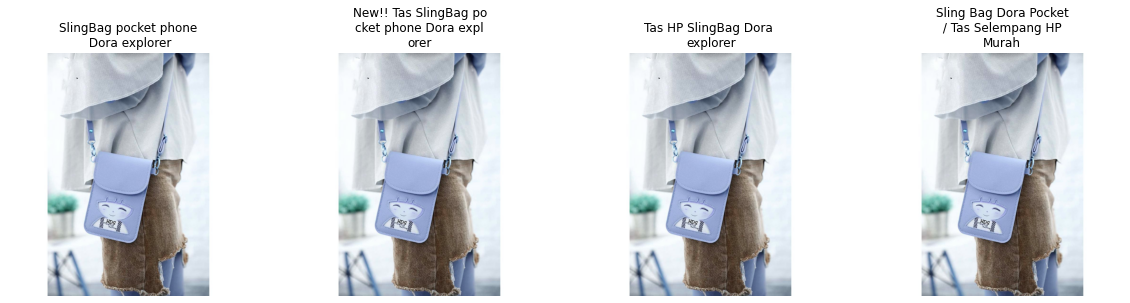

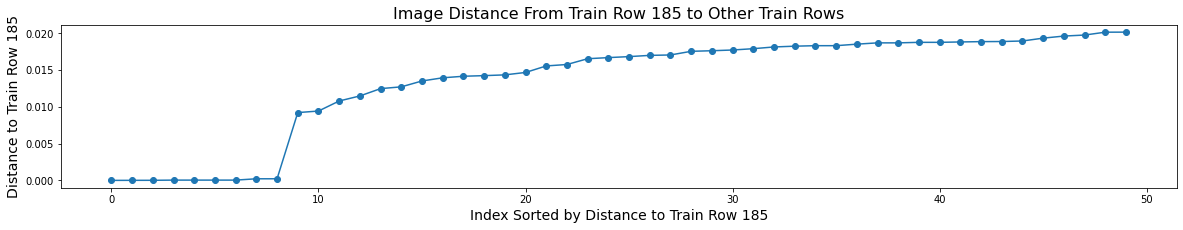

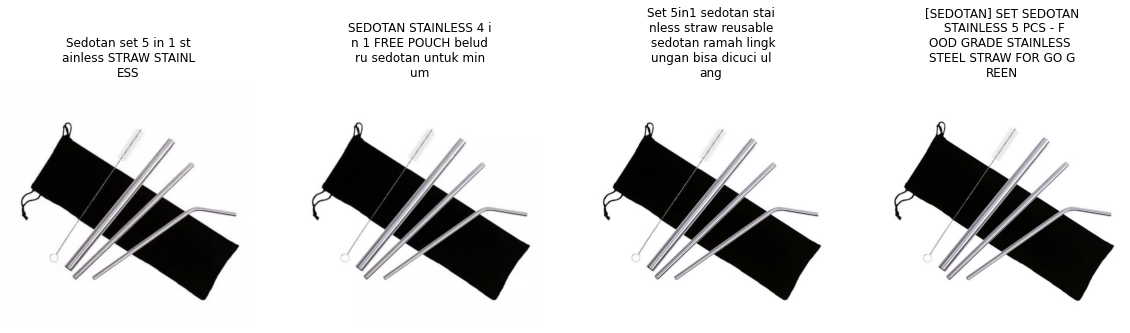

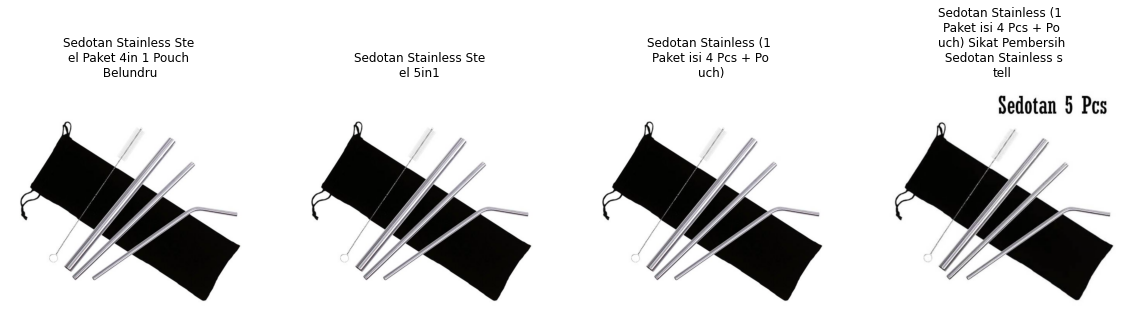

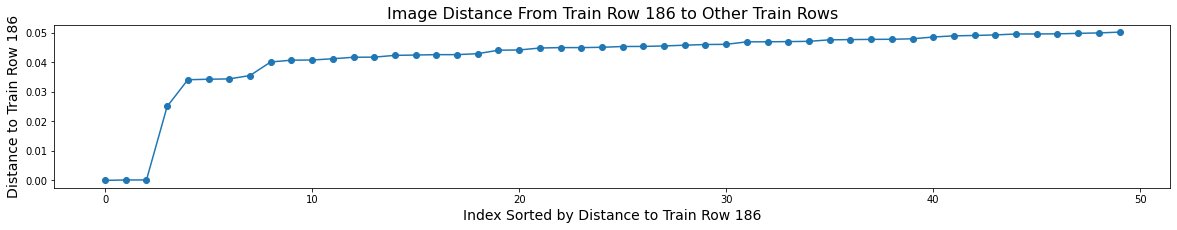

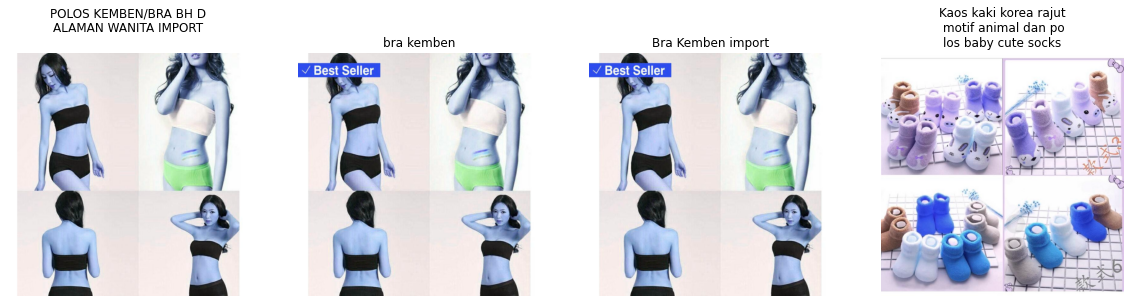

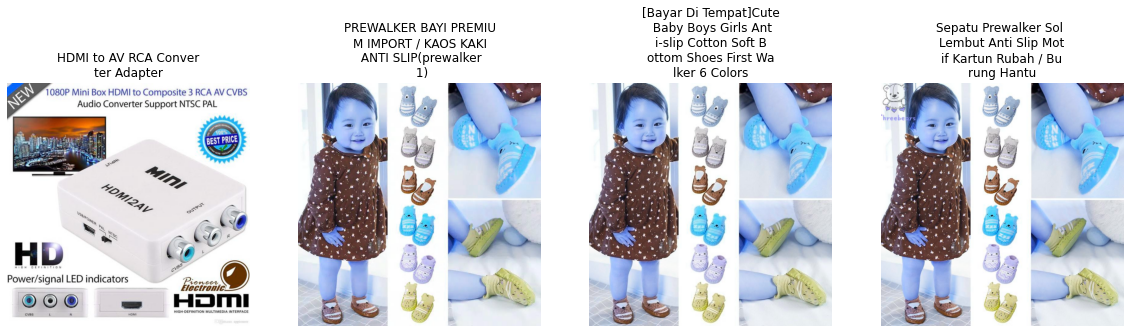

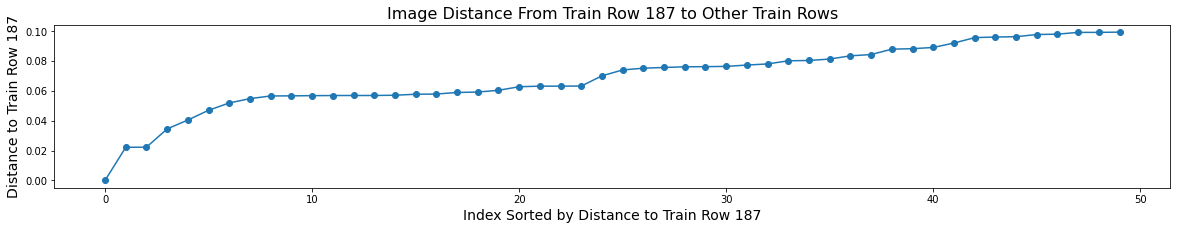

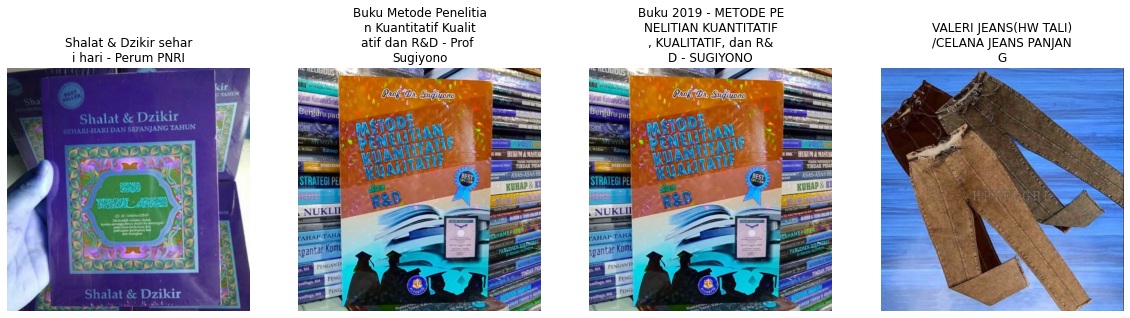

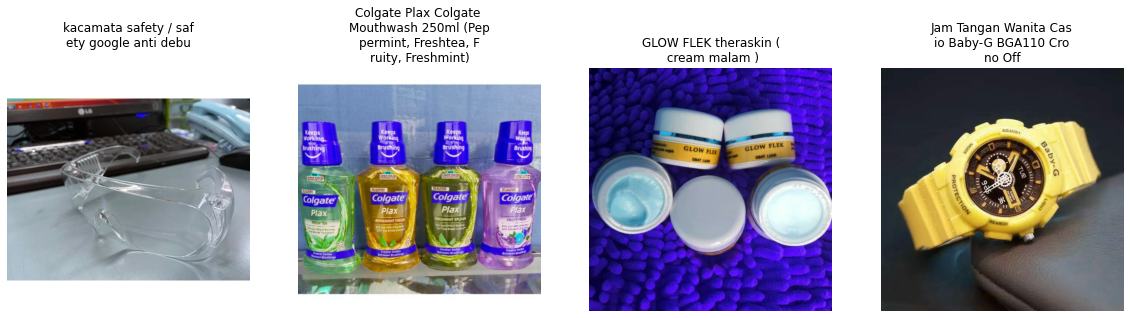

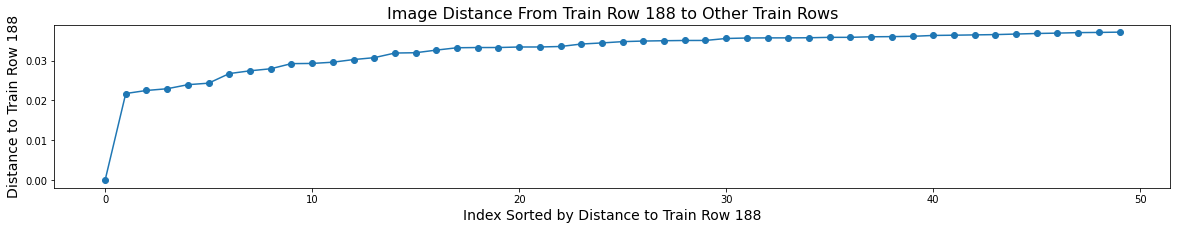

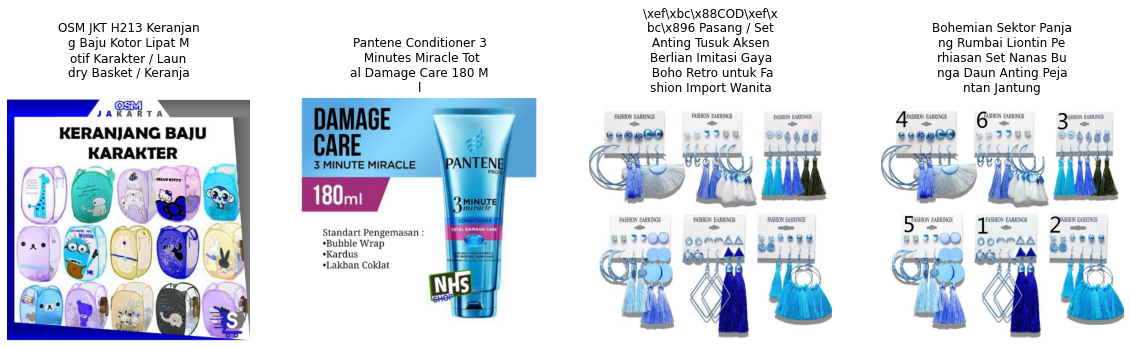

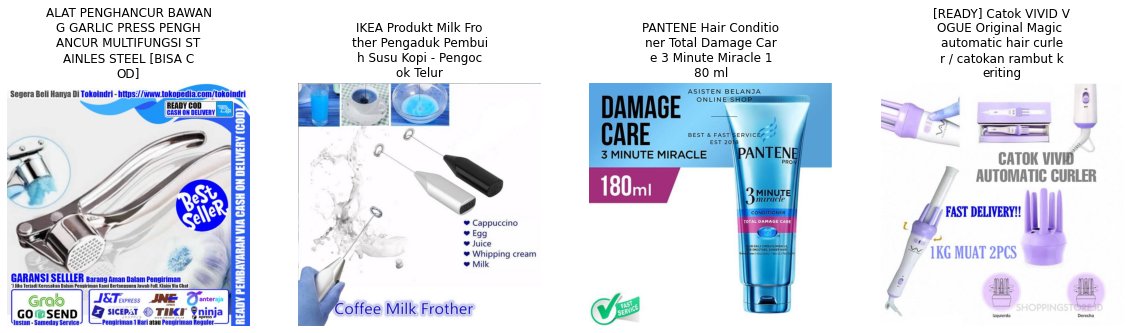

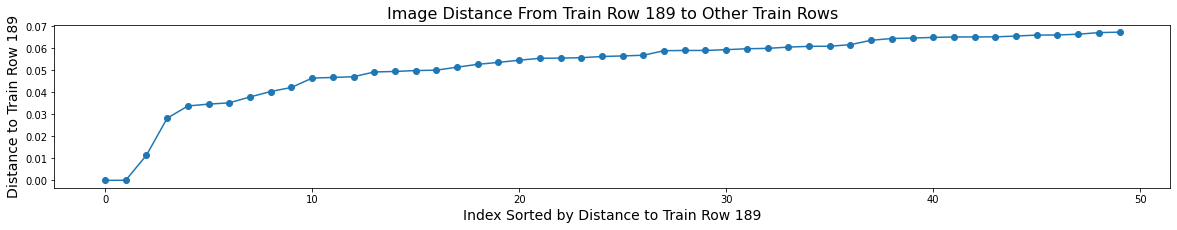

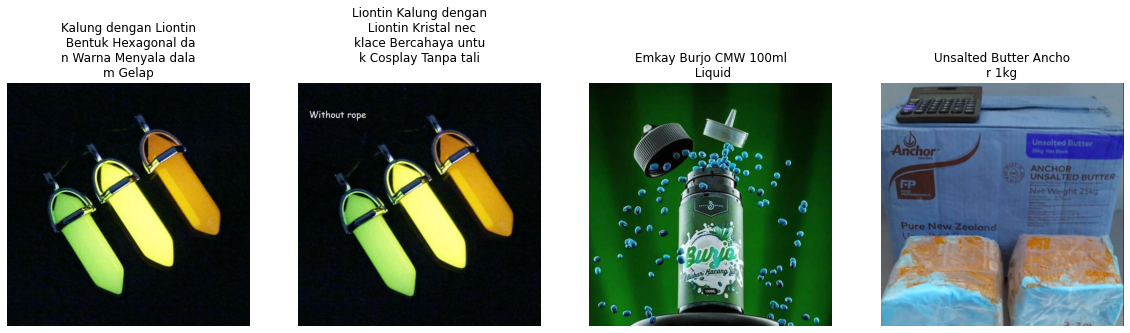

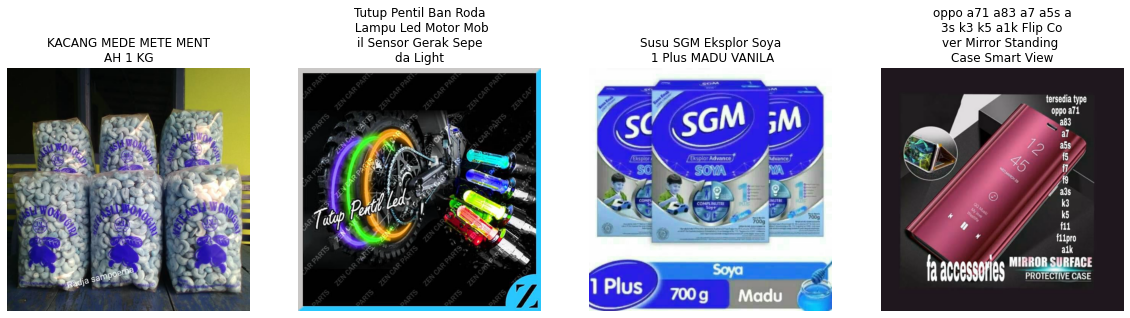

In [33]:
for k in range(180, 190):
    plt.figure(figsize=(20, 3))
    plt.plot(np.arange(50), distances[k,], 'o-')
    plt.title(f'Image Distance From Train Row {k} to Other Train Rows', size=16)
    plt.ylabel(f'Distance to Train Row {k}', size=14)
    plt.xlabel(f'Index Sorted by Distance to Train Row {k}', size=14)
    plt.show()
    
    cluster = train.loc[indices[k,:8]] 
    displayDF(cluster, random=False, ROWS=2, COLS=4)